<a href="https://colab.research.google.com/github/oikn2018/CS6910_assignment_2/blob/main/iNaturalist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import random
import wget
import os
import datetime
from zipfile import ZipFile
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [3]:
# classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [4]:
url='https://storage.googleapis.com/wandb_datasets/nature_12K.zip'
filename = os.path.basename(url)

if not os.path.exists(filename) and not os.path.exists("inaturalist_12K"):
  filename = wget.download(url)
  with ZipFile(filename, 'r') as z:
    print('Extracting files...')
    z.extractall()
    print('Done!')
  os.remove(filename)

In [22]:
classes = sorted([name for name in os.listdir("inaturalist_12K/train") if name != '.DS_Store'])
print(classes)

['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


In [6]:
image_size = (256,256)
num_layers = 5
num_classes = len(classes)

In [7]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.cnn_model = nn.Sequential(
        nn.Conv2d(3,16,5, padding=2), #(N, 3, 256, 256) -> (N, 16, 256, 256)
        nn.ReLU(),
        nn.MaxPool2d(2, stride = 2), #(N, 16, 256, 256) -> (N, 16, 128, 128)
        nn.Conv2d(16,16,5, padding=2), #(N, 16, 128, 128) -> (N, 16, 128, 128)
        nn.ReLU(),
        nn.MaxPool2d(2, stride = 2), # (N, 16, 128, 128) -> (N, 16, 64, 64)
        nn.Conv2d(16,16,5, padding=2), #(N, 16, 64, 64) -> (N, 16, 64, 64)
        nn.ReLU(),
        nn.MaxPool2d(2, stride = 2), # (N, 16, 64, 64) -> (N, 16, 32, 32)
        nn.Conv2d(16,16,5, padding=2), #(N, 16, 32, 32) -> (N, 16, 32, 32)
        nn.ReLU(),
        nn.MaxPool2d(2, stride = 2), # (N, 16, 32, 32) -> (N, 16, 16, 16)
        nn.Conv2d(16,16,5, padding=2), #(N, 16, 16, 16) -> (N, 16, 16, 16)
        nn.ReLU(),
        nn.MaxPool2d(2, stride = 2), # (N, 16, 16, 16) -> (N, 16, 8, 8)
    )
    self.fully_conn_model = nn.Sequential(
        nn.Linear(1024, 128), #(N, 59536) -> (N, 128)
        nn.ReLU(),
        nn.Linear(128, 64), # (N, 120) -> (N, 84)
        nn.ReLU(),
        nn.Linear(64, 10) # (N, 84) -> (N, 10)
    )
  
  def forward(self, x):
    # print(x.shape)
    x = self.cnn_model(x)
    # print(x.shape)
    x = x.view(x.size(0), -1) # (N, 16, 5, 5) -> (N, 400)
    # print(x. shape)
    x = self.fully_conn_model(x)
    # print(x.shape)
    return x

In [8]:
batch_size = 4
# trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform.ToTensor())
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(256),
    # transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))
])

transform_val = transforms.Compose([
    transforms.RandomResizedCrop(256),
    # transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))
])

train_dataset = ImageFolder(
    'inaturalist_12K/train',
    transform=transform_train
)

val_dataset = ImageFolder(
    'inaturalist_12K/train',
    transform=transform_val
)

# indexs = [[] for _ in range(len(train_dataset.classes))]  # you can't use `[[]] * len(dataset.classes)`. Although there might be better ways but I don't know
# for idx, (_, class_idx) in enumerate(train_dataset):
#     indexs[class_idx].append(idx)
# train_indices, val_indices = [], []
# for cl_idx in indexs:
#     size = len(cl_idx)
#     split = int(np.floor(0.2* size))
#     np.random.shuffle(cl_idx)
#     train_indices.extend(cl_idx[split:])
#     val_indices.extend(cl_idx[:split])
# train_sampler = SubsetRandomSampler(train_indices)
# valid_sampler = SubsetRandomSampler(val_indices)


# Define the indices to split between training and validation datasets
num_train = len(train_dataset)
indices = list(range(num_train))

split = int(np.floor(0.2 * num_train))

# Shuffle the indices before splitting
np.random.seed(0)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Define the samplers for training and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Use the samplers to create the DataLoader for validation set
val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset,
    batch_size=batch_size,
    sampler=val_sampler
    # shuffle = True
)


train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size=batch_size,
    sampler=train_sampler
    # shuffle = True
)

# print(len(train_dataset), len(val_dataset))

# trainloader = (trainset, batch_size = batch_size, shuffle = True)
# testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform.ToTensor())
# testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True)

1999


In [9]:
# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# print(images.shape)
# print(images[0].shape)
# print(labels[0].item())

torch.Size([4, 3, 256, 256])
torch.Size([3, 256, 256])
7


In [31]:
def imshow(img, title):
  npimg = img.numpy()/2 + 0.5
  plt.figure(figsize = (batch_size*3, 3))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.title(title)
  plt.show()

In [32]:
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title = [classes[x.item()] for x in labels])
  # imshow(img, title = [[x.item()] for x in labels])

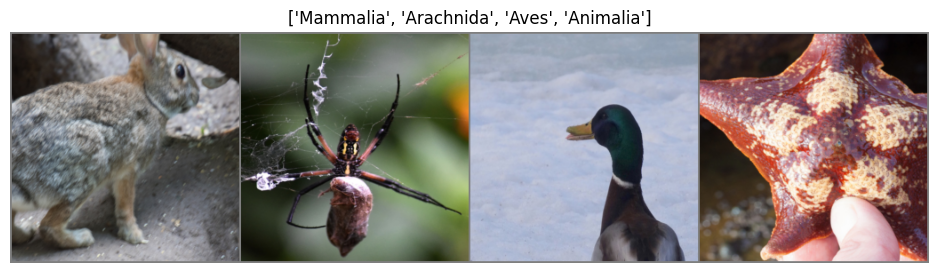

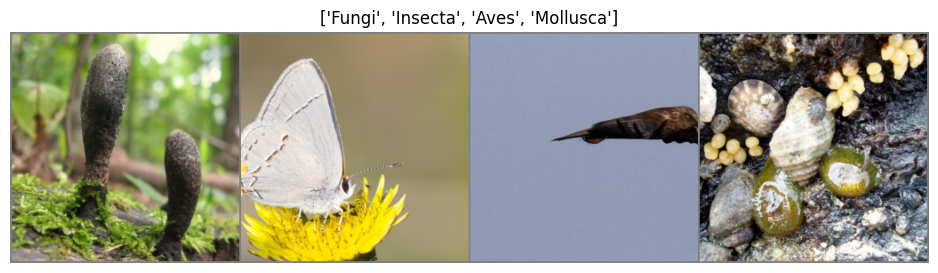

In [36]:
for i in range(2):
  show_batch_images(train_loader)

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [10]:
def evaluation(dataloader):
  total, correct = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    max_values, pred_class = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred_class == labels).sum().item()
  return 100*correct/total

In [11]:
net = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())
print(sum(p.numel() for p in net.parameters() if p.requires_grad))


166986


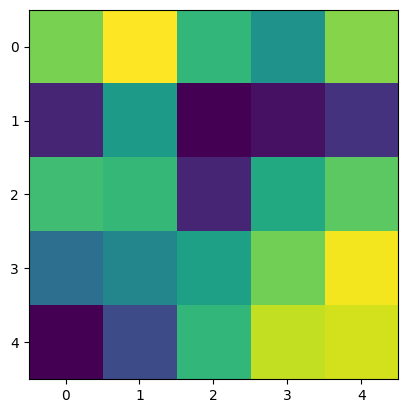

IndexError: ignored

In [12]:
for param in net.parameters():
  plt.imshow(param[0,2,:,:].to('cpu').detach().numpy())
  plt.show()

In [ ]:
%%time
loss_arr = []
loss_ep_arr = []
max_epochs = 10

for epoch in range(max_epochs):
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    opt.zero_grad()
    outputs = net(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()
    loss_arr.append(loss.item())
  loss_ep_arr.append(loss.item())
  print('Epoch: %d/%d, Validation accuracy: %0.2f, Train accuracy: %0.2f'%(epoch, max_epochs, evaluation(val_loader), evaluation(train_loader)))
# Epoch: 10/16, Test accuracy: 55.76, Train accuracy: 63.59
plt.plot(loss_ep_arr)
plt.show()

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
print(images[0].shape)
print(classes[labels[0].item()])

In [ ]:
img = images[0]
npimg = img.numpy()
npimg = np.transpose(npimg, (1,2,0))
print(npimg.shape)

In [ ]:
plt.figure(figsize=(1,1))
plt.imshow(npimg)
plt.show()

In [ ]:
net = CNN()
# loss_fn = nn.CrossEntropyLoss()
# opt = optim.Adam(net.parameters())
# print(sum(p.numel() for p in net.parameters() if p.requires_grad))
out = net(images)
print(out.shape())

In [26]:
imshow(torchvision.utils.make_grid(images))
print(' '.join(classes[labels[i]] for i in range(4) ))

TypeError: ignored